In [180]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

**Canonical System**

In [181]:
a_x = 1 # diminish term gain
run_time = 1.0
dt = 0.01 # time interval
time_steps = int(run_time / dt)
x_start = 1 # starting state

def CS_step(x, a_x, dt): # one step for Canonical System
  """
  Generate a single step of x for discrete
  (potentially closed) loop movements.
  Decaying from 1 to 0 according to dx = -ax*x.
  x: state value
  a_x: gain
  dt: time interval
  """
  # Your code here -------------------------------------------
  dx = -a_x * x * dt
  x += dx
  #---------------------------------------------------------------
  return x # return one step output

def CS_rollout(x_start, time_steps, a_x, dt):
  # Generate the sequence of x throughout the time steps with CS_step
  x_track = np.zeros(time_steps)
  x = x_start
  for t in range(time_steps):
    x_track[t] = x
    x = CS_step(x, a_x, dt)
  return x_track

In [182]:
x_track = CS_rollout(x_start, time_steps, a_x, dt)
print("dynamical system output: ", x_track)

dynamical system output:  [1.         0.99       0.9801     0.970299   0.96059601 0.95099005
 0.94148015 0.93206535 0.92274469 0.91351725 0.90438208 0.89533825
 0.88638487 0.87752102 0.86874581 0.86005835 0.85145777 0.84294319
 0.83451376 0.82616862 0.81790694 0.80972787 0.80163059 0.79361428
 0.78567814 0.77782136 0.77004315 0.76234271 0.75471929 0.74717209
 0.73970037 0.73230337 0.72498034 0.71773053 0.71055323 0.70344769
 0.69641322 0.68944909 0.6825546  0.67572905 0.66897176 0.66228204
 0.65565922 0.64910263 0.6426116  0.63618549 0.62982363 0.62352539
 0.61729014 0.61111724 0.60500607 0.59895601 0.59296645 0.58703678
 0.58116641 0.57535475 0.5696012  0.56390519 0.55826614 0.55268348
 0.54715664 0.54168508 0.53626823 0.53090554 0.52559649 0.52034052
 0.51513712 0.50998575 0.50488589 0.49983703 0.49483866 0.48989027
 0.48499137 0.48014146 0.47534004 0.47058664 0.46588078 0.46122197
 0.45660975 0.45204365 0.44752321 0.44304798 0.4386175  0.43423133
 0.42988901 0.42559012 0.42133422 0.

**Dynamics Movement Primitives**

**Calculate target forcing term value**

In [183]:
def DMP_imitate_path(n_dmps, time_steps, dt, run_time, y_des):
  """
  Takes in a desired trajectory and generates the set of
  system parameters that best realize this path.
  n_dmps: number of dmps, one per path, you can think of moving in 3D
  you have paths in x, y, and z directions.
  time_steps: number of time steps
  y_des list/array: the desired trajectories of each DMP
  """
  alpha_z = np.ones(n_dmps) * 25.0 # gain in point attractor dynamics
  beta_z = alpha_z / 4.0 # gain in point attractor dynamics
  goal = np.copy(y_des[:, -1])
  path = np.zeros((n_dmps, time_steps))
  y0 = y_des[:, 0].copy()
  x = np.linspace(0, run_time, y_des.shape[1])
  # interpolate the desired trajectory
  for d in range(n_dmps):
    path_gen = scipy.interpolate.interp1d(x, y_des[d])
    for t in range(time_steps):
        path[d, t] = path_gen(t * dt)
  y_des = path
  # calculate velocity and acceleration of y_des with central differences
  # Your code here -------------------------------------------
  dy_des = np.gradient(y_des, axis=1) / dt  # Velocity using central differences
  ddy_des = np.gradient(dy_des, axis=1) / dt # Acceleration using central differences
  #---------------------------------------------------------------
  # Calculate the target forcing terms
  # initialization
  f_target = np.zeros((y_des.shape[1], n_dmps))
  # Your code here -------------------------------------------
  for d in range(n_dmps):
    f_target[:, d] = ddy_des[d] - alpha_z[d] * (
        beta_z[d] * (goal[d] - y_des[d]) - dy_des[d]
    )
  #---------------------------------------------------------------
  return f_target

In [184]:
# 2D path
path_x = np.sin(np.arange(0, 1, 0.01) * 5)
path_y = np.zeros(path_x.shape)
path_y[int(len(path_y) / 2.0) :] = 0.5
n_dmps = 2
f_target = DMP_imitate_path(n_dmps, time_steps, dt, run_time, np.array([path_x, path_y]))

**Find the weights**

In [185]:
def gen_centres(run_time, n_bfs, a_x):
  """
  Set the centre of the Gaussian basis
  functions be spaced evenly throughout run time
  This is a design choice
  """
  des_c = np.linspace(0, run_time, n_bfs)
  c = np.ones(len(des_c))
  for n in range(len(des_c)):
    # finding x for desired times t
    c[n] = np.exp(-a_x * des_c[n])
  return c

def gen_psi(x, variances, centres_Gaussian_bfs):
  """
  Generates the activity of the basis functions for a given
  canonical system rollout.
  This is a design choice
  """
  if isinstance(x, np.ndarray):
      x = x[:, None]
  return np.exp(- variances * (x - centres_Gaussian_bfs) ** 2)

def gen_weights(f_target, x_track, n_dmps, n_bfs, variances, centres_Gaussian_bfs, y_des):
  """
  Generate a set of weights over the basis functions such
  that the target forcing term trajectory is matched.
  f_target np.array: the target forcing term trajectory
  x_track: rollout from the
  """
  # calculate psi
  psi_track = gen_psi(x_track, variances, centres_Gaussian_bfs)
  # efficiently calculate BF weights using weighted linear regression
  # initialization
  w = np.zeros((n_dmps, n_bfs)) # w: weights
  goal = np.copy(y_des[:, -1])
  # Your code here -------------------------------------------
  y0 = y_des[:, 0].copy()
  for d in range(n_dmps):
    # spatial scaling term
    k = goal[d] - y0[d]
    for b in range(n_bfs):
        numer = np.sum(x_track * psi_track[:, b] * f_target[:, d])
        denom = np.sum(x_track ** 2 * psi_track[:, b])
        w[d, b] = numer / denom
        if abs(k) > 1e-5:
            w[d, b] /= k

  w = np.nan_to_num(w)
  #---------------------------------------------------------------
  return w

**Trajectory generation**

In [186]:
def DMP_step(x, a_x, dt, n_dmps, variances, centres_Gaussian_bfs, weights, y_des, y, dy, ddy):
  """
  Run the DMP system for a given x value.
  """
  alpha_z = np.ones(n_dmps) * 25.0 # gain in point attractor dynamics
  beta_z = alpha_z / 4.0 # gain in point attractor dynamics
  goal = np.copy(y_des[:, -1])  # set the goal of system as the last component in the trajectory
  psi = gen_psi(x, variances, centres_Gaussian_bfs)

  for d in range(n_dmps):
      # calculate the forcing term
      # Your code here -------------------------------------------
      f = np.dot(psi, weights[d]) * a_x  # Calculate the forcing term
      #---------------------------------------------------------------
      # DMP formulation
      # calculate position velocity and acceleration of DMP output
      # using the forceing term
      # name your variable with the following:
      # position: y
      # velocity: dy
      # acceleration: ddy
      # Your code here -------------------------------------------
      ddy[d] = alpha_z[d] * (beta_z[d] * (goal[d] - y[d]) - dy[d]) + f  # Acceleration
      dy[d] += ddy[d] * dt  # Velocity update
      y[d] += dy[d] * dt  # Position update
      #---------------------------------------------------------------
  return y, dy, ddy

def DMP_rollout(x_start, time_steps, n_dmps, a_x, dt, variances, centres_Gaussian_bfs, weights, y_des):
  """
  Generate a system trial, with DMP_step no feedback is incorporated.
  Note that the system start with 0 poistion, velocity and acceleration
  x_start is always 1 for simplicity.
  """
  # set up tracking vectors
  y_track = np.zeros((time_steps, n_dmps))
  dy_track = np.zeros((time_steps, n_dmps))
  ddy_track = np.zeros((time_steps, n_dmps))
  x = x_start
  for t in range(time_steps - 1):
    # run and record timestep
    x = CS_step(x, a_x, dt)
    y_track[t + 1], dy_track[t + 1], ddy_track[t + 1] = DMP_step(x, a_x, dt, n_dmps, variances, centres_Gaussian_bfs, weights, y_des, y_track[t], dy_track[t], ddy_track[t])
  return y_track, dy_track, ddy_track

**Run the DMPs**

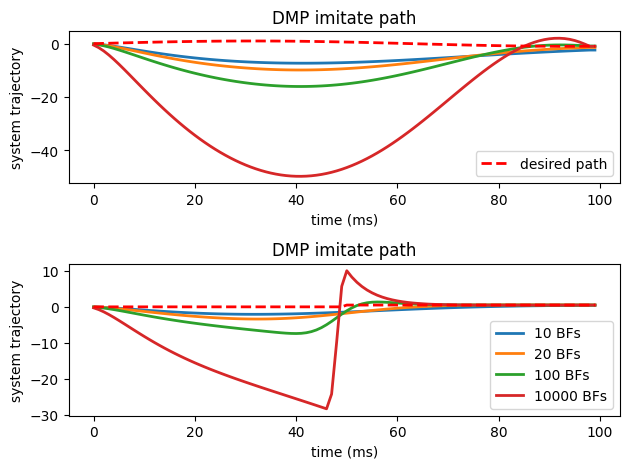

In [187]:
# different number of basis functions
list_of_n_bfs = [10, 20, 100, 10000]
y_des=np.array([path_x, path_y])
for ii, bfs in enumerate(list_of_n_bfs):
  centres_Gaussian_bfs = gen_centres(run_time, list_of_n_bfs[ii], a_x)
  variances = np.ones(list_of_n_bfs[ii]) * list_of_n_bfs[ii] ** 1.5 / centres_Gaussian_bfs / a_x
  psi = gen_psi(x_track, variances, centres_Gaussian_bfs)
  weights = gen_weights(f_target, x_track, n_dmps, list_of_n_bfs[ii], variances, centres_Gaussian_bfs, np.array([path_x, path_y]))
  y_track, dy_track, ddy_track = DMP_rollout(1, time_steps, n_dmps, a_x, dt, variances, centres_Gaussian_bfs, weights, y_des)
  plt.figure(2)
  plt.subplot(211)
  plt.plot(y_track[:, 0], lw=2)
  plt.subplot(212)
  plt.plot(y_track[:, 1], lw=2)
plt.figure(2, figsize=(6, 4))
plt.subplot(211)
a = plt.plot(path_x, "r--", lw=2)
plt.title("DMP imitate path")
plt.xlabel("time (ms)")
plt.ylabel("system trajectory")
plt.legend([a[0]], ["desired path"], loc="lower right")
plt.subplot(212)
b = plt.plot(path_y, "r--", lw=2)
plt.title("DMP imitate path")
plt.xlabel("time (ms)")
plt.ylabel("system trajectory")
plt.legend(["%i BFs" % i for i in list_of_n_bfs], loc="lower right")
plt.tight_layout()
plt.show()